# Heterogeneous Construction

In [1]:
%load_ext autoreload
%autoreload 2

# System imports
import sys
import yaml
import logging

# External imports
import matplotlib.pyplot as plt
import numpy as np

# import seaborn as sns
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import  WandbLogger
from tqdm import tqdm

import warnings
logging.basicConfig(level=logging.INFO)

warnings.filterwarnings("ignore")
sys.path.append("../../..")
device = "cuda" if torch.cuda.is_available() else "cpu"

from hetero_utils import build_hetero_graphs
from LightningModules.Filter.Models.vanilla_filter import VanillaFilter
from LightningModules.Filter.Models.pyramid_filter import PyramidFilter
from LightningModules.Filter.Models.hetero_pyramid import HeteroPyramidFilter
from LightningModules.GNN.Models.hetero_gnn import HeteroGNN

## Setup

In [4]:
with open("hetero_filter.yaml") as f:
    hparams = yaml.load(f, Loader=yaml.FullLoader)

In [5]:
model = HeteroPyramidFilter(hparams)

## Build New HeteroGraphs

In [5]:
base_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/embedding_processed/0GeV_v3"
new_save_path = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/hetero_embedding_processed/0GeV_v3"
build_hetero_graphs(base_dir, new_save_path, max_events=2000, use_process_map=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validate some stuff...

## Dataset Validation

First, let's look at the distribution of true and fake in each volume ID

In [47]:
model.setup(stage="fit")

In [48]:
sample = model.trainset[0]

In [49]:
sample

Data(x=[342088, 9], cell_data=[342088, 11], pid=[342088], event_file='/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000016278', hid=[342088], pt=[342088], primary=[342088], nhits=[342088], modules=[342088], modulewise_true_edges=[2, 137265], signal_true_edges=[2, 15674], edge_index=[2, 121278], y=[121278], volume_id=[342088], y_pid=[121278])

In [53]:
model.all_combos

tensor([[0, 0],
        [0, 1],
        [0, 2],
        [0, 3],
        [1, 1],
        [1, 2],
        [1, 3],
        [2, 2],
        [2, 3],
        [3, 3]])

In [50]:
true = sample.edge_index[:, sample.y]
fake = sample.edge_index[:, ~sample.y]

In [51]:
true_vol_id = sample.volume_id[true]
fake_vol_id = sample.volume_id[fake]

In [10]:
vol_lookup = torch.tensor([[0, 1, 2, 3], [1, 4, 5, 6], [2, 5, 7, 8], [3, 6, 8, 9]])

In [11]:
true_edge_volume = vol_lookup[true_vol_id[0], true_vol_id[1]]
fake_edge_volume = vol_lookup[fake_vol_id[0], fake_vol_id[1]]

In [28]:
# Get random selection of fake edge volumes
fake_edge_volume = fake_edge_volume[torch.randperm(fake_edge_volume.shape[0])]

In [29]:
fake_edge_volume = fake_edge_volume[:true_edge_volume.shape[0]*10]

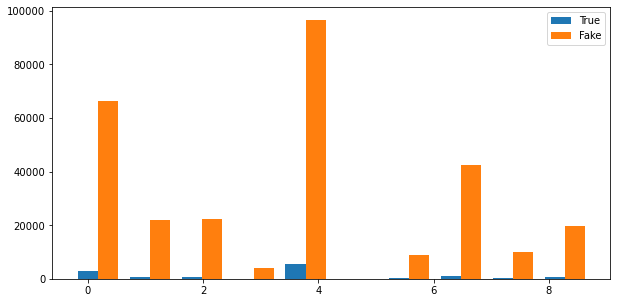

In [12]:
# Make histogram of edge volume by fake and true
true_hist, true_bins = np.histogram(true_edge_volume, bins=10)
fake_hist, fake_bins = np.histogram(fake_edge_volume, bins=10)
# Make bar chart of true_hist and fake_hist side by side
width = 0.35
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(true_bins[:-1], true_hist, width, label="True")
plt.bar(fake_bins[:-1] + width, fake_hist, width, label="Fake")
plt.legend()
plt.show()

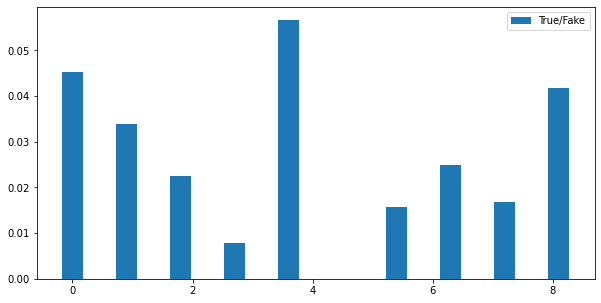

In [13]:
# Make histogram of edge volume by fake and true
true_hist, true_bins = np.histogram(true_edge_volume, bins=10)
fake_hist, fake_bins = np.histogram(fake_edge_volume, bins=10)
# Make bar chart of true_hist / fake_hist
width = 0.35
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(true_bins[:-1], true_hist / fake_hist, width, label="True/Fake")
plt.legend()

### Dynamic Combos

In [125]:
vol_list = [[0, 1, 2], [3]]

In [126]:
vol_list

[[0, 1, 2], [3]]

In [127]:
combos = torch.tensor([[0,0], [0, 1], [1,1]])

In [128]:
combos

tensor([[0, 0],
        [0, 1],
        [1, 1]])

In [129]:
labels = torch.tensor([0, 1, 2])

In [130]:
labels

tensor([0, 1, 2])

In [131]:
all_vol_ids = torch.empty(4, 4)

In [132]:
all_vol_ids

tensor([[ 4.2389e-06,  4.5584e-41, -1.4209e-02,  3.0872e-41],
        [ 0.0000e+00,  1.8750e+00,  0.0000e+00,  1.8750e+00],
        [ 0.0000e+00,  1.8750e+00,  0.0000e+00,  1.8750e+00],
        [ 0.0000e+00,  4.7684e-06,  0.0000e+00,  1.8750e+00]])

In [134]:
all_vol_ids = torch.empty(4, 4)
for i, combo in enumerate(combos):
    print(combo)
    stacked_combo = torch.stack(torch.meshgrid(torch.tensor(vol_list[combo[0]]), torch.tensor(vol_list[combo[1]])), dim=-1).flatten(0,1).T
    stacked_combo = torch.cat([stacked_combo, stacked_combo.flip(0)], dim=-1)
    print(stacked_combo)
    all_vol_ids[stacked_combo[0], stacked_combo[1]] = i
    print(all_vol_ids)

tensor([0, 0])
tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2],
        [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2]])
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0871e-41],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([0, 1])
tensor([[0, 1, 2, 3, 3, 3],
        [3, 3, 3, 0, 1, 2]])
tensor([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 1., 1., 0.]])
tensor([1, 1])
tensor([[3, 3],
        [3, 3]])
tensor([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 1., 1., 2.]])


In [118]:
stacked_combo = torch.stack(torch.meshgrid(vol_list[combo][0], vol_list[combo][1]), dim=-1).flatten(0,1).T

In [120]:
stacked_combo = torch.cat([stacked_combo, stacked_combo.flip(0)], dim=-1)

In [121]:
stacked_combo

tensor([[2, 2, 3, 3, 2, 3, 2, 3],
        [2, 3, 2, 3, 2, 2, 3, 3]])

In [114]:
stacked_combo.flatten(0, 1)

tensor([[2, 2],
        [2, 3],
        [3, 2],
        [3, 3]])

In [85]:
combo

tensor([1, 1])

In [86]:
vol_list[combo][0], vol_list[combo][1]

(tensor([2, 3]), tensor([2, 3]))

In [103]:
stacked_combo = torch.stack(torch.meshgrid(vol_list[combo][0], vol_list[combo][1]), dim=-1)

In [108]:
all_vol_ids[stacked_combo[0], stacked_combo[1]]

tensor([[0., 0.],
        [0., 0.]])

## Train Filter

In [7]:
logger = WandbLogger(
    project=hparams["project"], group="Balanced", save_dir=hparams["artifacts"]
)
trainer = Trainer(
    gpus=1, max_epochs=hparams["max_epochs"], logger=logger
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | edge_encoders | ModuleList | 7.2 M 
---------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.754    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Performance Validation

### Roadmap

1. Make model loading function
2. Make robust inference function
3. Make well-partitioned eta & pt performance functions
4. Make performance plotting function

In [2]:
from gnn_utils import run_eta_performance, run_pt_performance

### Build Pre-constructed performance evaluation function

In [12]:
model.setup(stage='fit')

In [ ]:
def run_eta_performance(checkpoint_path, model_type, dataset_type, num_events, score_cut, common_axes = None, vmin=[None, None, None], vmax=[None, None, None]):
    model, _ = load_model(checkpoint_path, model_type)
    results = inference(model, dataset_type, num_events)
    get_topline_stats(results, score_cut)
    av_eta_pred, av_eta_signal_true, av_eta_signal_true_pos, av_eta_bkg_true_pos, av_r_pred, av_r_signal_true, av_r_signal_true_pos, av_r_bkg_true_pos = build_edge_eta_list(results)
    eff_ax, signal_pur_ax, bkg_pur_ax = plot_metrics(av_eta_pred, av_eta_signal_true, av_eta_signal_true_pos, av_eta_bkg_true_pos, common_axes = common_axes)
    if common_axes is None:
        plot_eta_r_metrics(av_eta_pred, av_eta_signal_true, av_eta_signal_true_pos, av_eta_bkg_true_pos, av_r_pred, av_r_signal_true, av_r_signal_true_pos, av_r_bkg_true_pos, vmin=vmin, vmax=vmax)

    return eff_ax, signal_pur_ax, bkg_pur_ax

In [ ]:
model.valset[0]

Data(x=[295698, 9], cell_data=[295698, 11], pid=[295698], event_file='/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010912', hid=[295698], pt=[295698], primary=[295698], nhits=[295698], modules=[295698], modulewise_true_edges=[2, 117468], signal_true_edges=[2, 15501], edge_index=[2, 581597], y=[581597], y_pid=[581597], volume_id=[295698], pid_signal=[581597])

In [17]:
def build_construction_eta_list(model, dataset_type, num_events):
    assert dataset_type in ["train", "val", "test"] , "dataset type must be one of ['train', 'val', 'test']"

    # Get dataset
    dataset_name = f"{dataset_type}set"

    trainsplit_dict = {"train": 0, "val": 1, "test": 2}
    model.hparams["datatype_split"] = [1, 1, 1]
    model.hparams["datatype_split"][trainsplit_dict[dataset_type]] = num_events
    model.setup(stage="fit")
    dataset = getattr(model, dataset_name)

    av_eta_pred, av_eta_signal_true, av_eta_signal_true_pos, av_eta_bkg_true_pos = [], [], [], []
    av_r_pred, av_r_signal_true, av_r_signal_true_pos, av_r_bkg_true_pos = [], [], [], []

    for result in tqdm(dataset):

        edge_pos = result.edge_index
        edge_signal_true = result.signal_true_edges
        edge_signal_true_pos = result.edge_index[:, result.y]
        edge_bkg_true_pos = result.edge_index[:, result.y_pid]

        eta_hits = calc_eta(result.x[:, 0], result.x[:, 2])
        av_eta_pred.append((eta_hits[edge_pos[0]] + eta_hits[edge_pos[1]]) / 2)
        av_eta_signal_true.append((eta_hits[edge_signal_true[0]] + eta_hits[edge_signal_true[1]]) / 2)
        av_eta_signal_true_pos.append((eta_hits[edge_signal_true_pos[0]] + eta_hits[edge_signal_true_pos[1]]) / 2)
        av_eta_bkg_true_pos.append((eta_hits[edge_bkg_true_pos[0]] + eta_hits[edge_bkg_true_pos[1]]) / 2)

        r_hits = result.x[:, 0]
        av_r_pred.append((r_hits[edge_pos[0]] + r_hits[edge_pos[1]]) / 2)
        av_r_signal_true.append((r_hits[edge_signal_true[0]] + r_hits[edge_signal_true[1]]) / 2)
        av_r_signal_true_pos.append((r_hits[edge_signal_true_pos[0]] + r_hits[edge_signal_true_pos[1]]) / 2)
        av_r_bkg_true_pos.append((r_hits[edge_bkg_true_pos[0]] + r_hits[edge_bkg_true_pos[1]]) / 2)


    # Concatenate all lists of tensors
    av_eta_pred = torch.cat(av_eta_pred)
    av_eta_signal_true = torch.cat(av_eta_signal_true)
    av_eta_signal_true_pos = torch.cat(av_eta_signal_true_pos)
    av_eta_bkg_true_pos = torch.cat(av_eta_bkg_true_pos)

    av_r_pred = torch.cat(av_r_pred)
    av_r_signal_true = torch.cat(av_r_signal_true)
    av_r_signal_true_pos = torch.cat(av_r_signal_true_pos)
    av_r_bkg_true_pos = torch.cat(av_r_bkg_true_pos)
    

    return av_eta_pred, av_eta_signal_true, av_eta_signal_true_pos, av_eta_bkg_true_pos, av_r_pred, av_r_signal_true, av_r_signal_true_pos, av_r_bkg_true_pos

In [22]:
av_eta_pred, av_eta_signal_true, av_eta_signal_true_pos, av_eta_bkg_true_pos, av_r_pred, av_r_signal_true, av_r_signal_true_pos, av_r_bkg_true_pos = build_construction_eta_list(model, "val", 100)

100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


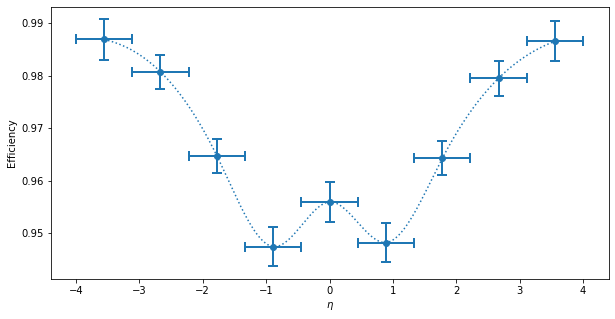

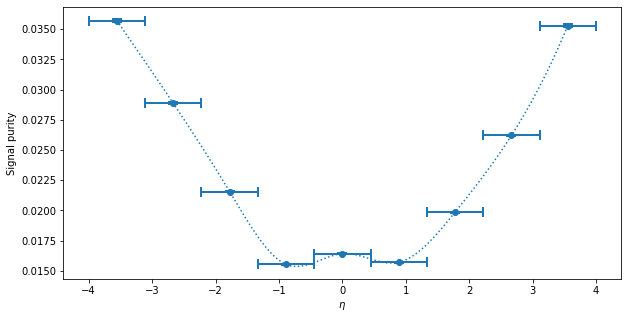

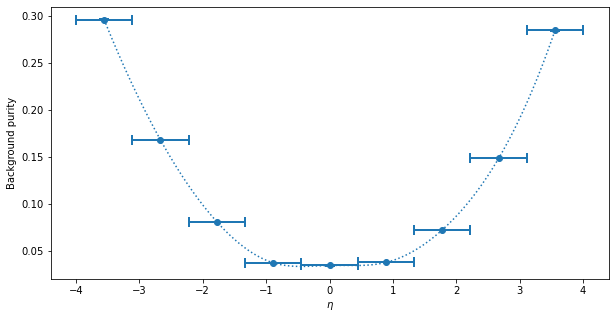

In [23]:
eff_ax, signal_pur_ax, bkg_pur_ax = plot_metrics(av_eta_pred, av_eta_signal_true, av_eta_signal_true_pos, av_eta_bkg_true_pos)

In [19]:
from gnn_utils import calc_eta, plot_metrics, plot_eta_r_metrics

### Full Detector Filter Performance

Single model across whole detector:

100%|██████████| 10/10 [00:00<00:00, 42.21it/s]


Signal efficiency: tensor(0.9809) Signal purity: tensor(0.0214) Background purity: tensor(0.1037)


100%|██████████| 10/10 [00:00<00:00, 16.54it/s]


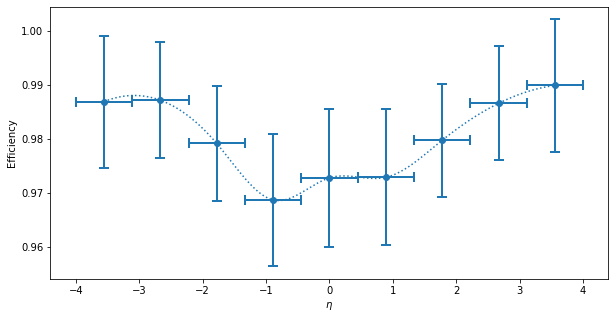

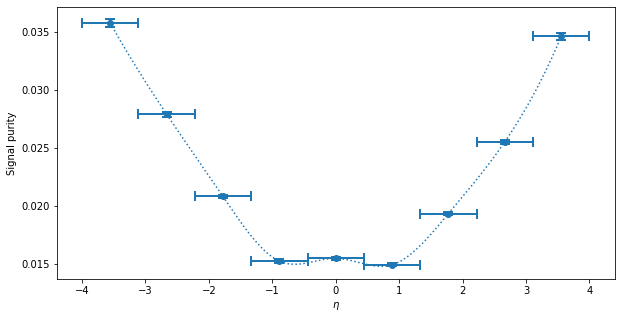

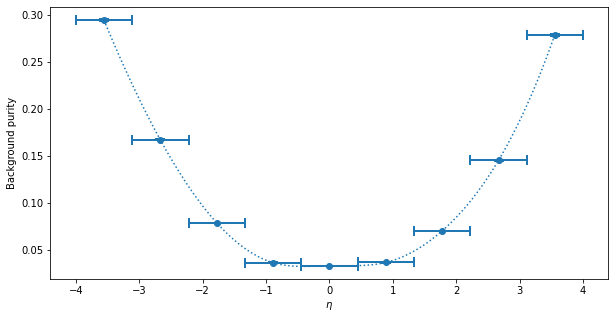

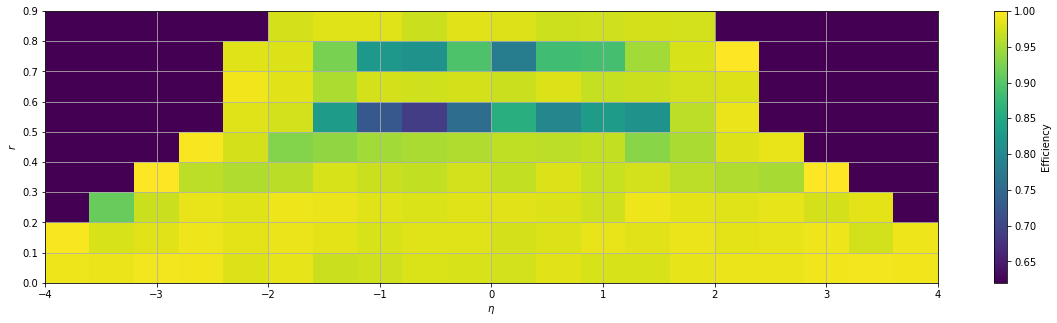

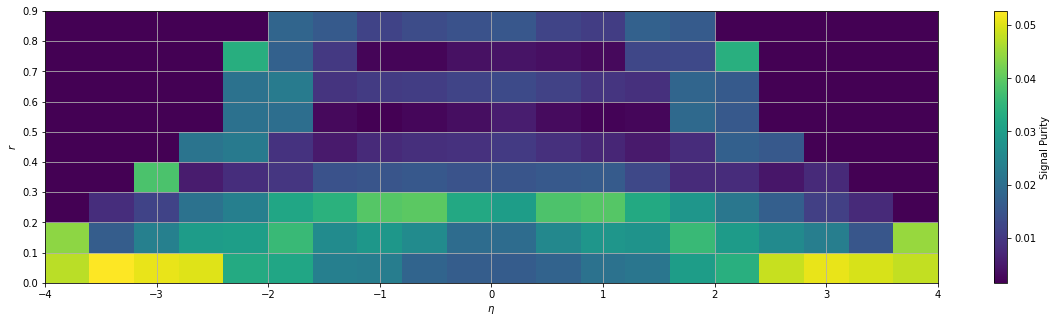

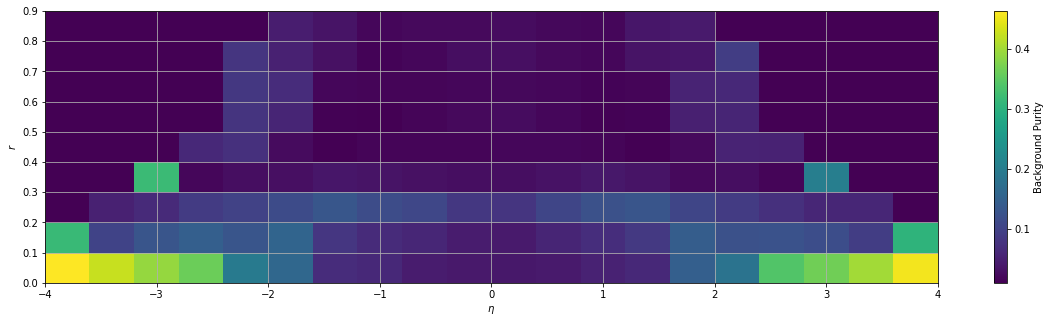

In [6]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_Filter/c7wpdlpv/checkpoints"
single_model_figs = run_eta_performance(checkpoint_path, PyramidFilter, "val", 10, 0.15, signal_true_label="y", bkg_true_label="y_pid")

Unbalanced training with multi-model

100%|██████████| 10/10 [00:00<00:00, 67.04it/s]


Signal efficiency: tensor(0.9813) Signal purity: tensor(0.0240) Background purity: tensor(0.1791)


100%|██████████| 10/10 [00:00<00:00, 13.92it/s]


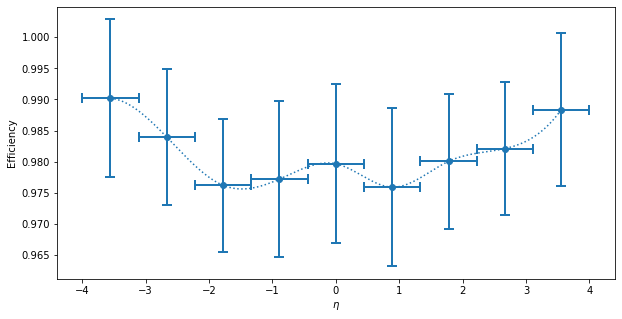

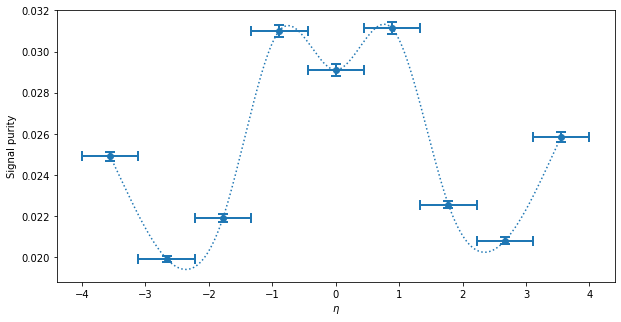

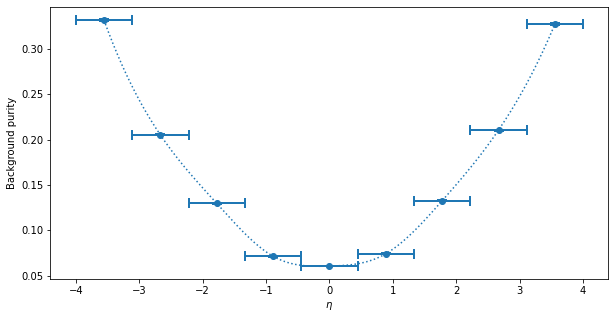

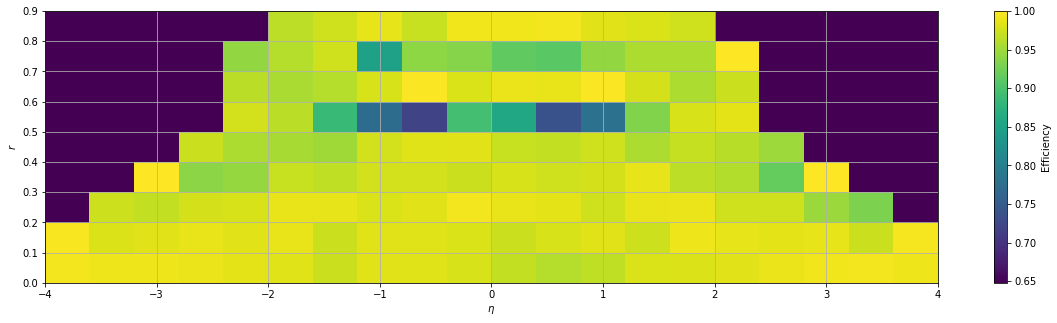

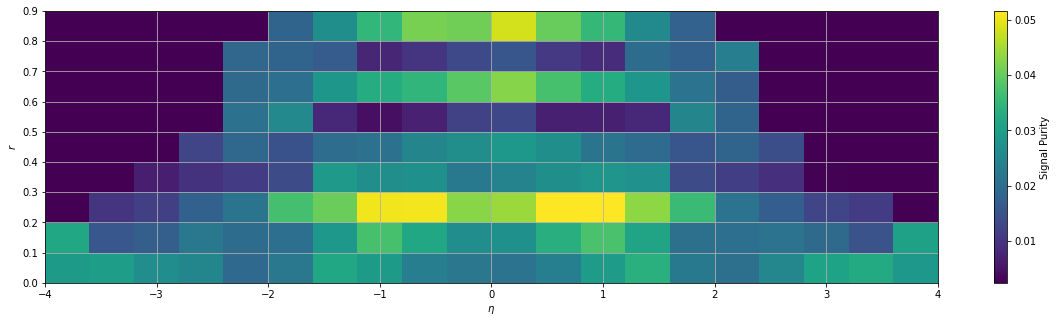

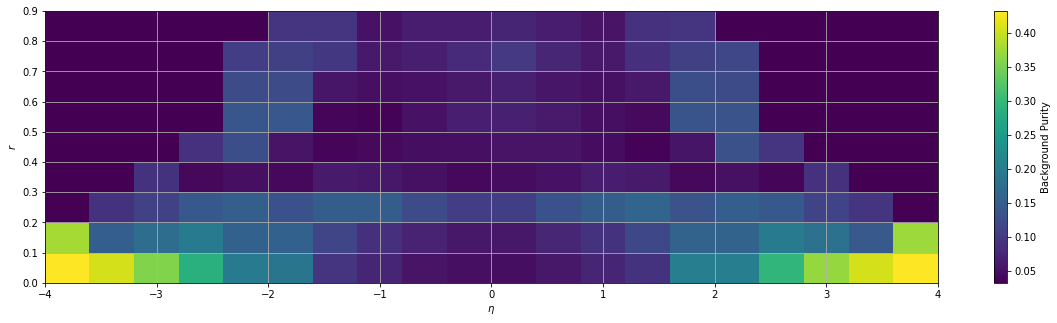

In [12]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_HeteroFilter/2kjaceyl/checkpoints/last.ckpt"
four_model_figs = run_eta_performance(checkpoint_path, HeteroPyramidFilter, "val", 10, 0.18, signal_true_label="y", bkg_true_label="y_pid")

Balanced training with multi-model

100%|██████████| 10/10 [00:00<00:00, 55.61it/s]


Signal efficiency: tensor(0.9813) Signal purity: tensor(0.0215) Background purity: tensor(0.1629)


100%|██████████| 10/10 [00:00<00:00, 11.73it/s]


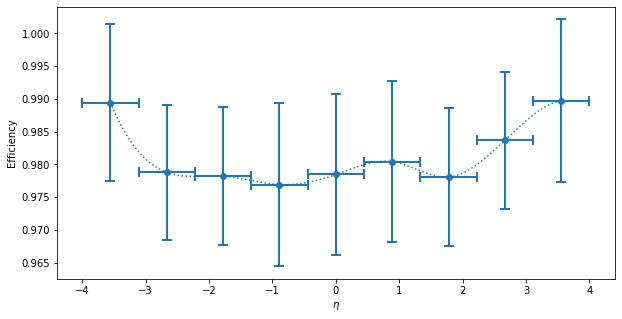

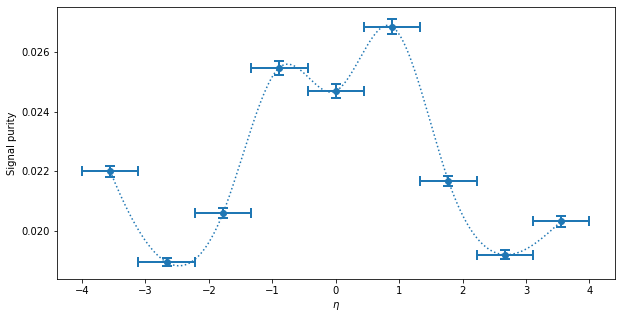

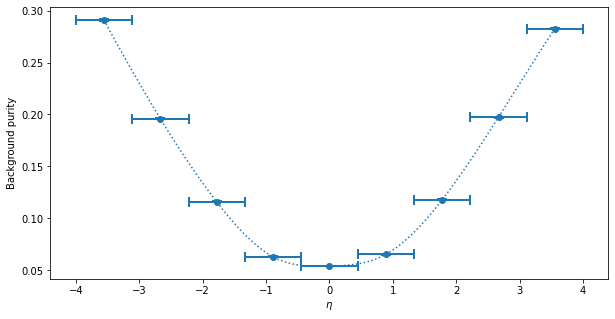

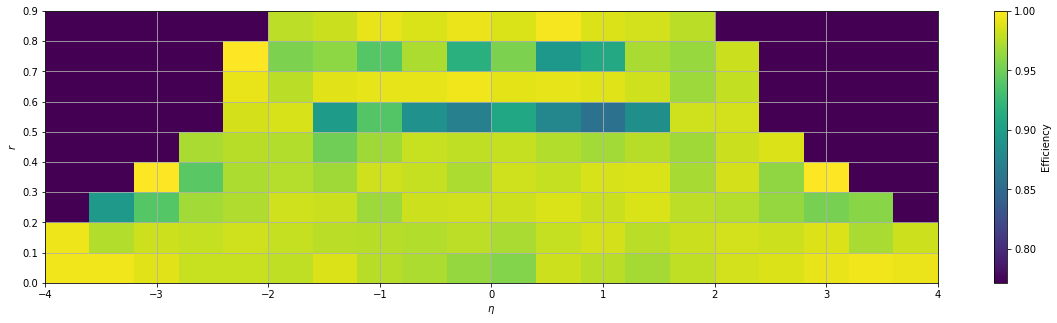

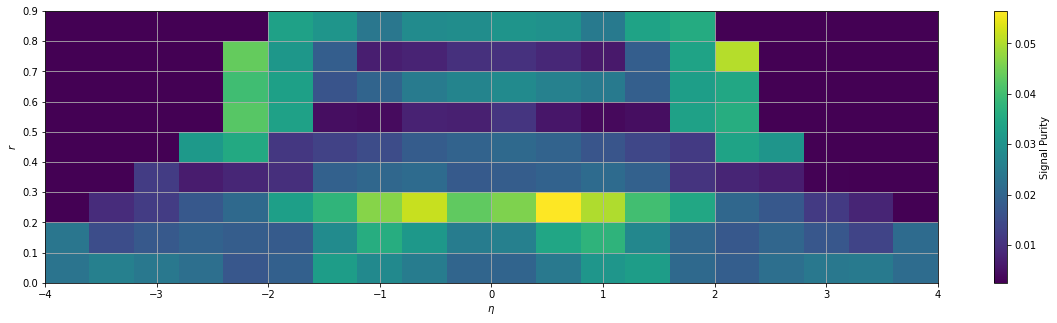

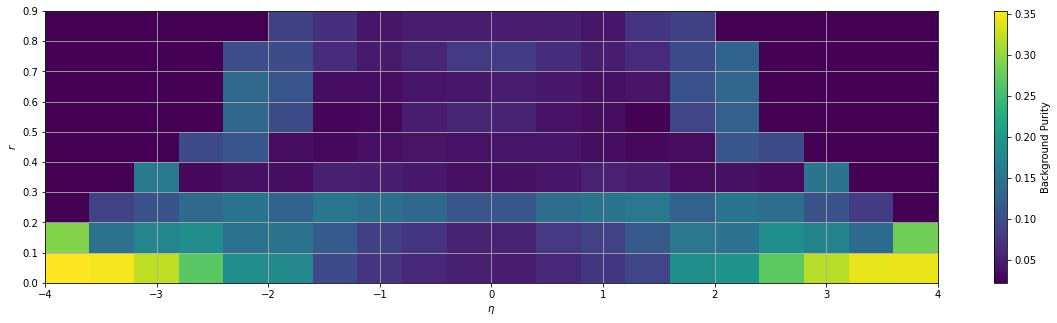

In [9]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_HeteroFilter/32nn1b7q/checkpoints/epoch=998-step=99899.ckpt"
four_model_figs = run_eta_performance(checkpoint_path, HeteroPyramidFilter, "val", 10, 0.5, signal_true_label="y", bkg_true_label="y_pid")

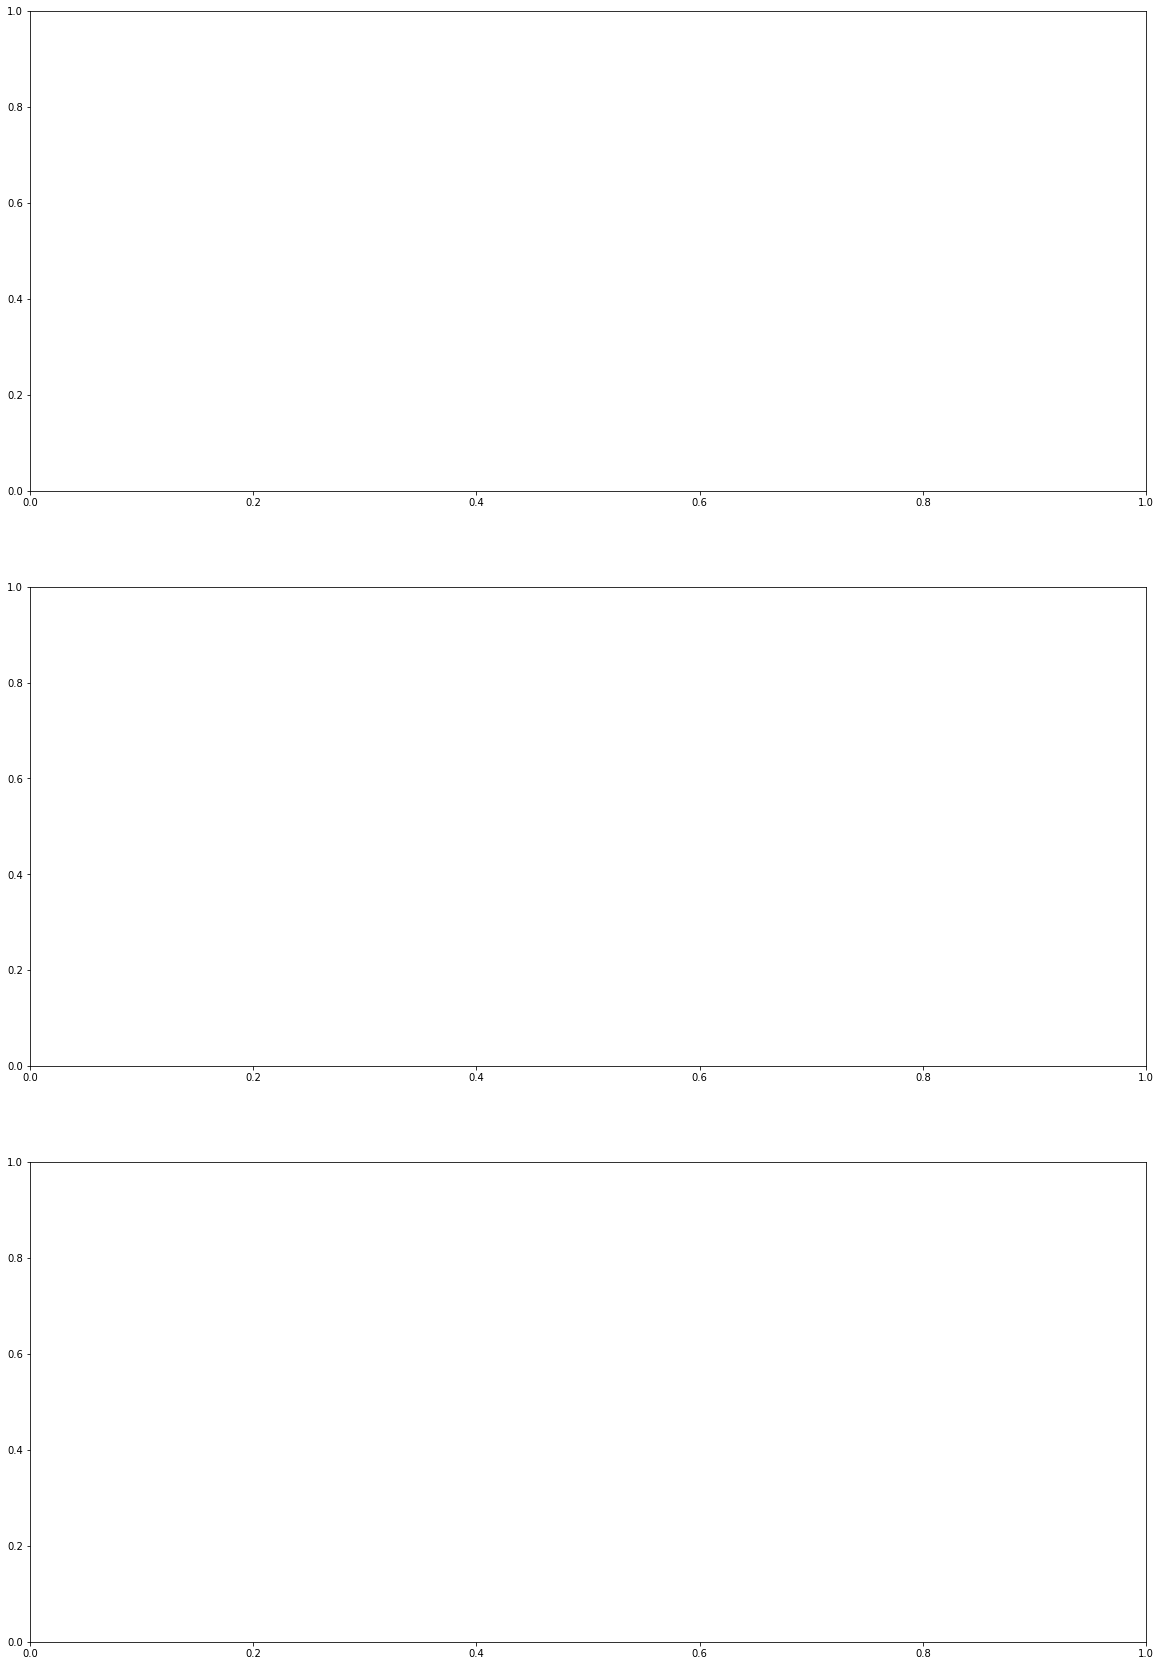

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(20, 30));

In [19]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_Filter/c7wpdlpv/checkpoints"
single_model_figs = run_eta_performance(checkpoint_path, PyramidFilter, "val", 100, 0.15, signal_true_label="y", bkg_true_label="y_pid", common_axes = axs)

100%|██████████| 100/100 [00:04<00:00, 22.76it/s]


Signal efficiency: tensor(0.9808) Signal purity: tensor(0.0220) Background purity: tensor(0.1056)


100%|██████████| 100/100 [00:04<00:00, 22.52it/s]


In [20]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_HeteroFilter/2kjaceyl/checkpoints/last.ckpt"
four_model_figs = run_eta_performance(checkpoint_path, HeteroPyramidFilter, "val", 100, 0.18, signal_true_label="y", bkg_true_label="y_pid", common_axes = axs)

100%|██████████| 100/100 [00:03<00:00, 26.83it/s]


Signal efficiency: tensor(0.9814) Signal purity: tensor(0.0232) Background purity: tensor(0.1728)


100%|██████████| 100/100 [00:06<00:00, 14.77it/s]


In [21]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_HeteroFilter/32nn1b7q/checkpoints/epoch=998-step=99899.ckpt"
four_model_figs = run_eta_performance(checkpoint_path, HeteroPyramidFilter, "val", 100, 0.5, signal_true_label="y", bkg_true_label="y_pid", common_axes = axs)

100%|██████████| 100/100 [00:04<00:00, 24.13it/s]


Signal efficiency: tensor(0.9827) Signal purity: tensor(0.0219) Background purity: tensor(0.1641)


100%|██████████| 100/100 [00:06<00:00, 15.56it/s]


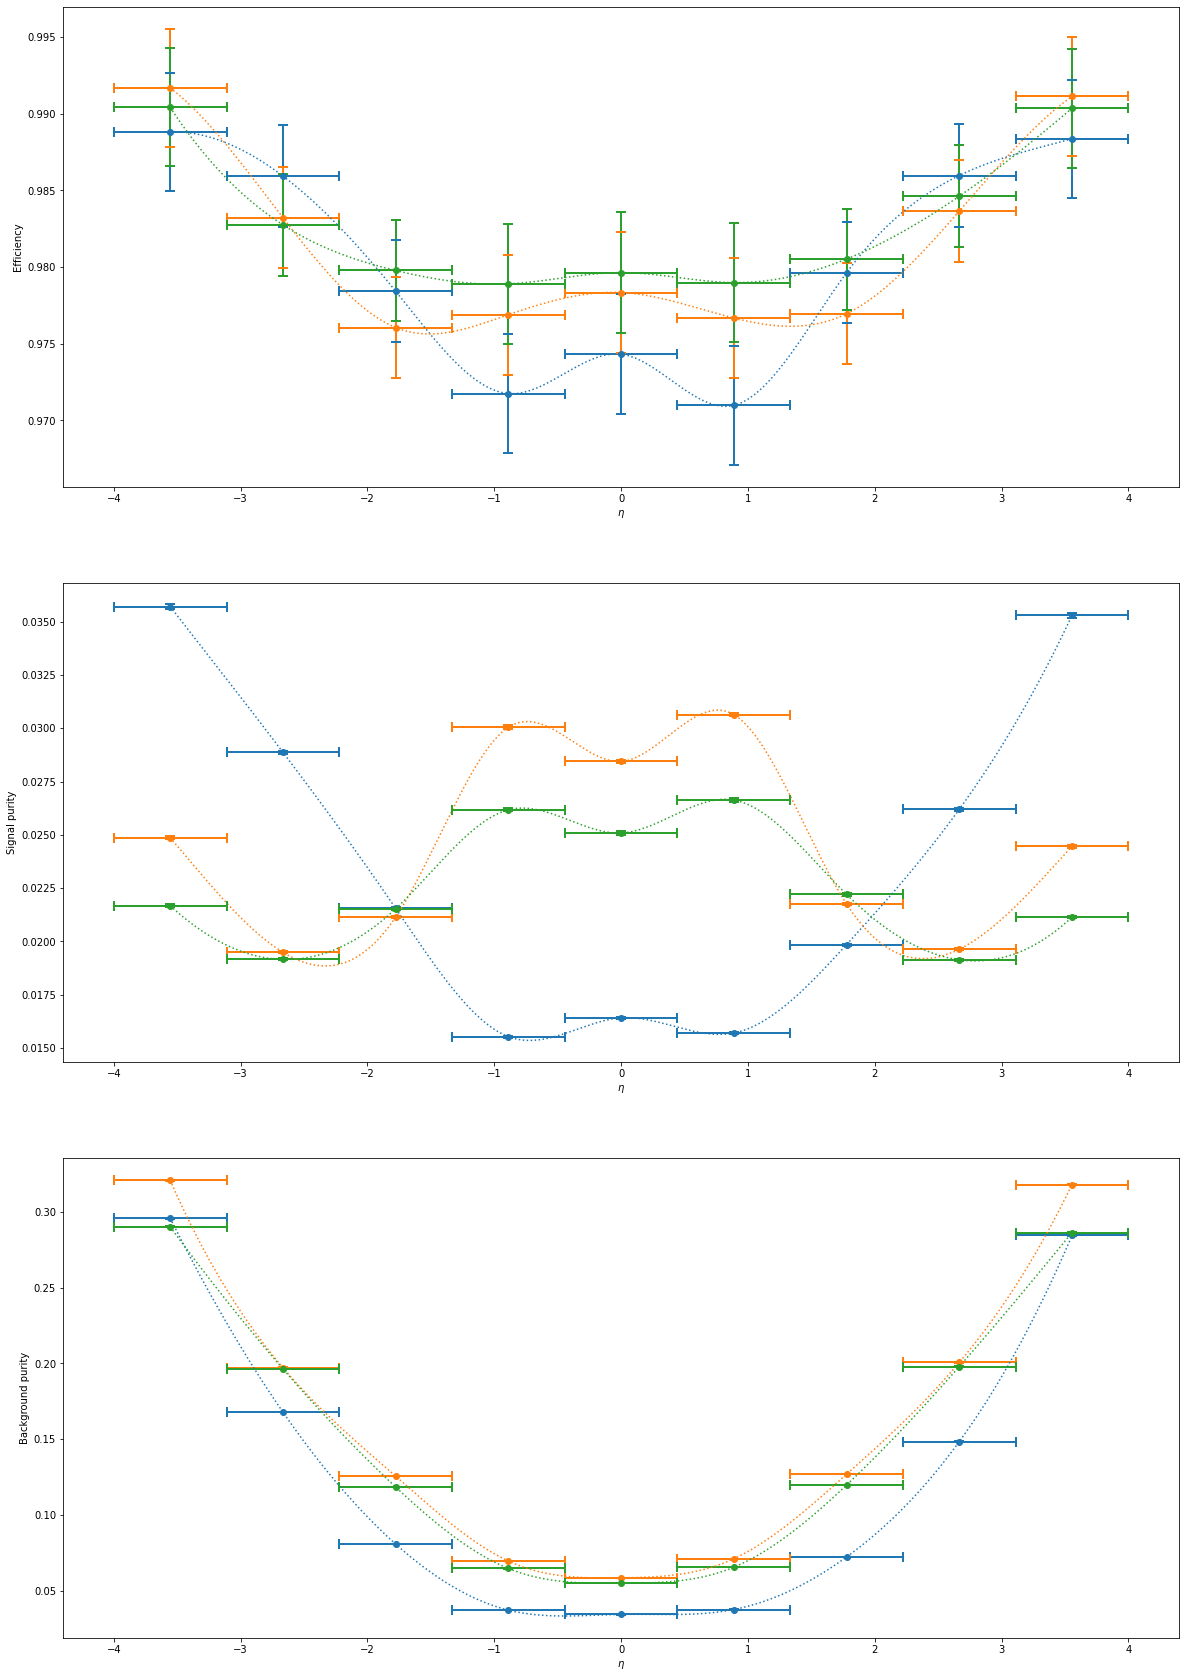

In [22]:
fig

#### pT Plots

100%|██████████| 100/100 [00:00<00:00, 1890.74it/s]


Signal efficiency: tensor(0.9489) Signal purity: tensor(0.4010) Background purity: tensor(0.8434)


100%|██████████| 100/100 [00:00<00:00, 298.55it/s]


[<AxesSubplot:xlabel='$p_{T} (MeV)$', ylabel='Efficiency'>, None, None]

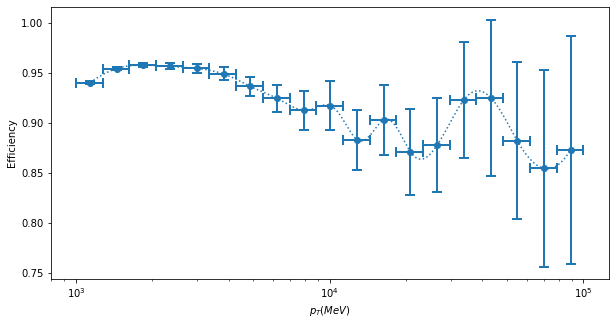

In [70]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_GNN/1j1uwy9r/checkpoints/epoch=76-step=38499.ckpt"
run_pt_performance(checkpoint_path, InteractionGNN, "train", 100, 0.5)

100%|██████████| 100/100 [00:00<00:00, 2123.03it/s]


Signal efficiency: tensor(0.9706) Signal purity: tensor(0.4638) Background purity: tensor(0.9371)


100%|██████████| 100/100 [00:00<00:00, 333.96it/s]


[<AxesSubplot:xlabel='$p_{T} (MeV)$', ylabel='Efficiency'>, None, None]

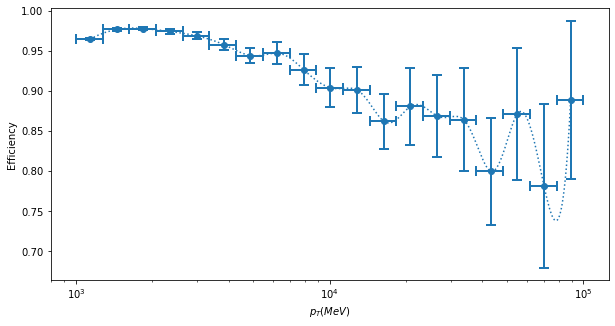

In [71]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_HeteroGNN/z8txsx3g/checkpoints/epoch=84-step=19786.ckpt"
run_pt_performance(checkpoint_path, HeteroGNN, "train", 100, 0.5)

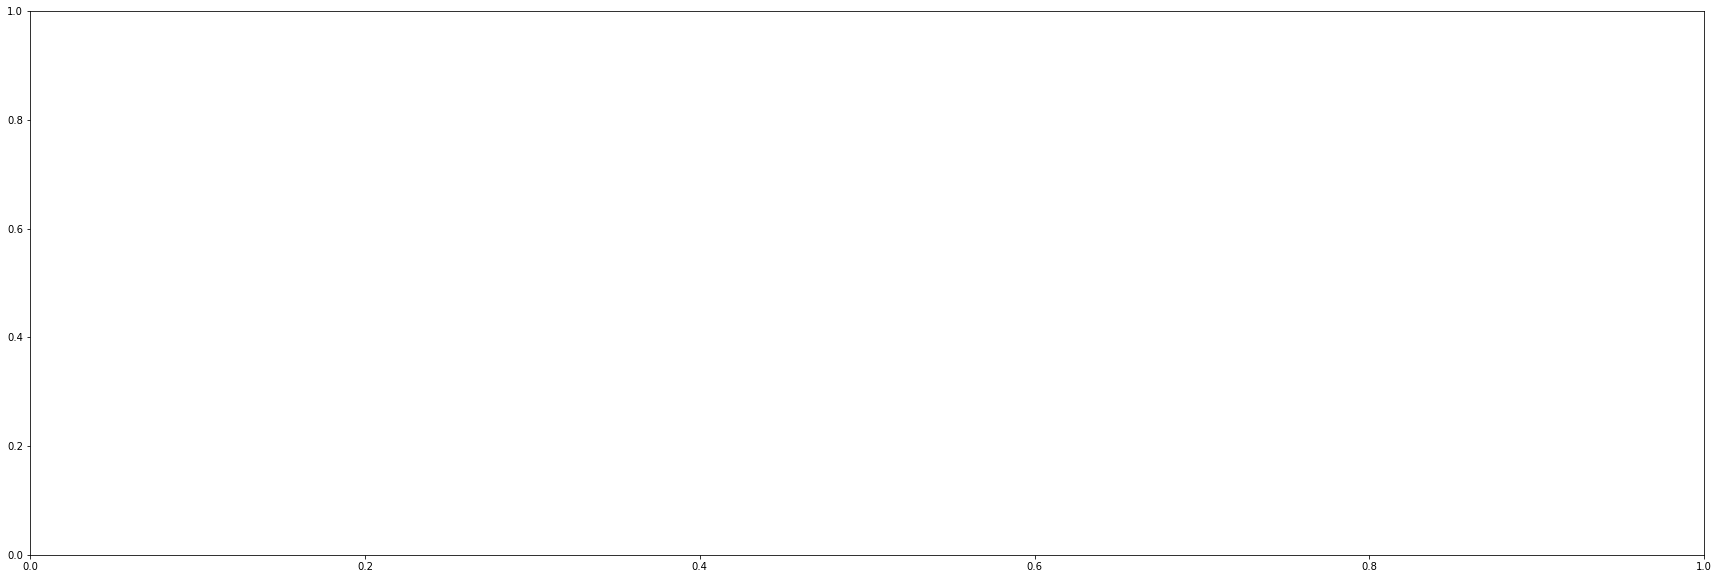

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(30, 10));

In [73]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_GNN/1j1uwy9r/checkpoints/epoch=76-step=38499.ckpt"
single_model_figs = run_pt_performance(checkpoint_path, InteractionGNN, "train", 200, 0.5, common_axes = axs)

100%|██████████| 200/200 [00:00<00:00, 1262.23it/s]


Signal efficiency: tensor(0.9480) Signal purity: tensor(0.3990) Background purity: tensor(0.8424)


100%|██████████| 200/200 [00:00<00:00, 297.92it/s]


In [74]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_HeteroGNN/z8txsx3g/checkpoints/epoch=84-step=19786.ckpt"
quadruple_model_figs = run_pt_performance(checkpoint_path, HeteroGNN, "train", 200, 0.5, common_axes = axs)

100%|██████████| 200/200 [00:00<00:00, 1370.61it/s]


Signal efficiency: tensor(0.9708) Signal purity: tensor(0.4636) Background purity: tensor(0.9374)


100%|██████████| 200/200 [00:00<00:00, 309.84it/s]


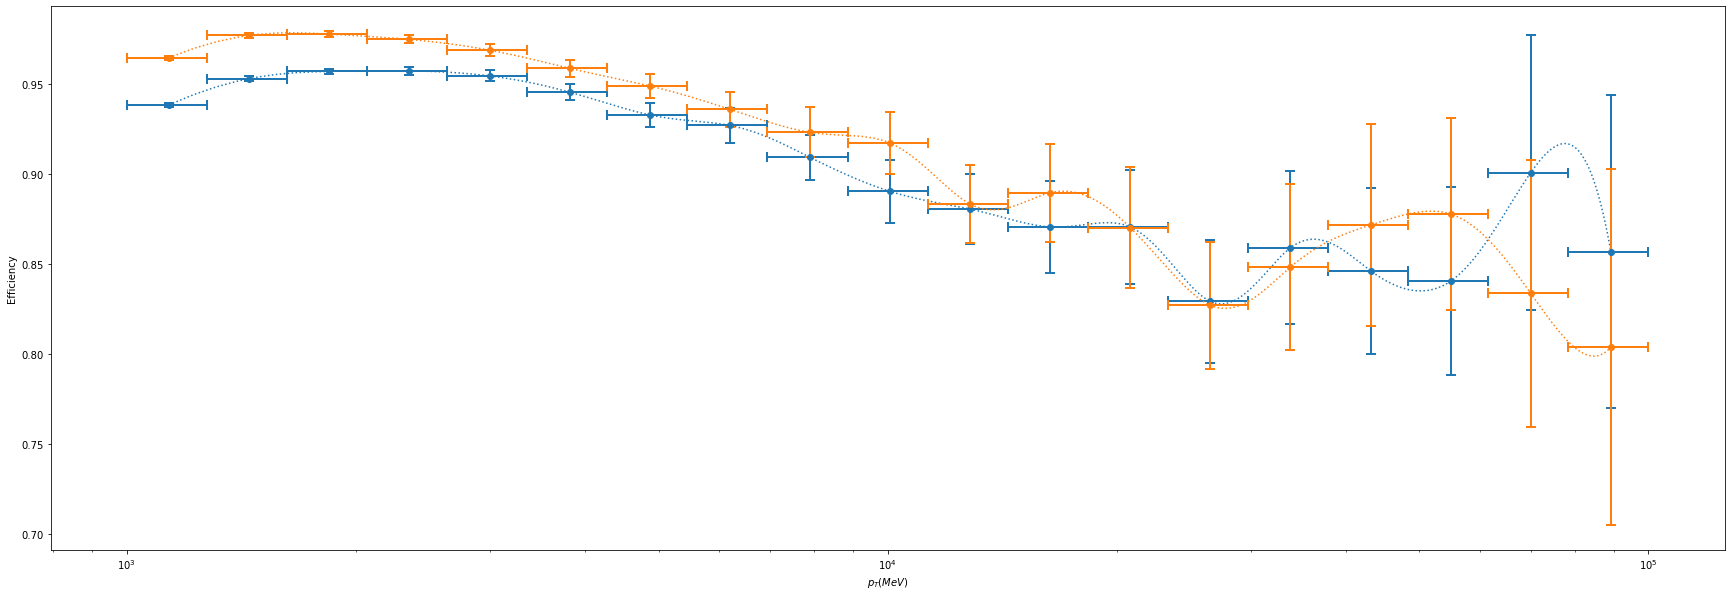

In [75]:
fig

### Develop Better Plotter Based on XY Functions

In [89]:
from scipy import stats

In [84]:
from gnn_utils import load_model, inference, get_topline_stats, build_edge_eta_list, calc_eta

In [80]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_HeteroGNN/z8txsx3g/checkpoints/epoch=84-step=19786.ckpt"
model, _ = load_model(checkpoint_path, HeteroGNN)
model.setup(stage="fit")

In [81]:
sample = model.trainset[0]

In [120]:
pt, eta = [], []

for sample in model.trainset[:100]:
    valid_pt = (sample.pt == sample.pt) & (sample.pt > 1000)
    pt.append(sample.pt[valid_pt])
    eta.append(calc_eta(sample.x[:, 0], sample.x[:, 2])[valid_pt])

# Concat
pt = np.concatenate(pt)
eta = np.concatenate(eta)

In [121]:
num_bins = 12
bins = np.linspace(-4, 4, num_bins)
mean = stats.binned_statistic(eta, pt, bins=bins)[0]
median = stats.binned_statistic(eta, pt, bins=bins, statistic="median")[0]
max = stats.binned_statistic(eta, pt, bins=bins, statistic="max")[0]
std = stats.binned_statistic(eta, pt, bins=bins, statistic="std")[0]

([<matplotlib.lines.Line2D at 0x7f099454e460>],
 Text(0.5, 0, '$\\eta$'),
 Text(0, 0.5, 'mean $p_T$ (MeV)'))

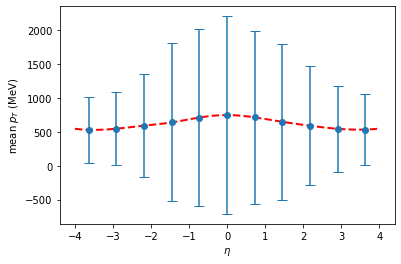

In [116]:
# Mean and std across eta bins
centers = (bins[:-1] + bins[1:]) / 2
plt.errorbar(centers, mean, yerr=std, fmt="o", capsize=5)

# Add cubic spline trendline
spline = scipy.interpolate.UnivariateSpline(centers, mean, k=3, s=0)
x = np.linspace(-4, 4, 100)
plt.plot(x, spline(x), "r--", lw=2), plt.xlabel("$\eta$"), plt.ylabel("mean $p_T$ (MeV)")


Text(-4.0, -4.0, '$p_T > 1GeV$')

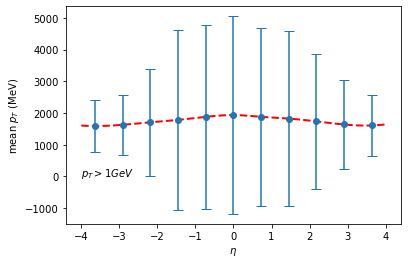

In [135]:
# Mean and std across eta bins
centers = (bins[:-1] + bins[1:]) / 2
plt.errorbar(centers, mean, yerr=std, fmt="o", capsize=5)

# Add cubic spline trendline
spline = scipy.interpolate.UnivariateSpline(centers, mean, k=3, s=0)
x = np.linspace(-4, 4, 100)
plt.plot(x, spline(x), "r--", lw=2), plt.xlabel("$\eta$"), plt.ylabel("mean $p_T$ (MeV)")
# Add text in corner of plot
plt.text(-4., -4., "$p_T > 1GeV$", fontsize=10)
